# Le Bitcoin par pays

Auteurs:

Marc Lagoin, Majeure IMAGE

Amaury LECOQ, Majeure SANTE

**L'objectif de notre projet de big data en python est d'analyser les échanges réalisés sur la blockchain du Bitcoin en fonction des pays des différents acteurs.** 

**Notre hypothèse principale est que les lois ou les marchés de chaque pays peut influencer le nombre d'échanges sur la blockchain ou le cours du Bitcoin.**


In [4]:
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install requests


[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: pip3 install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: pip3 install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: pip3 install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: pip3 install --upgrade pip


In [5]:
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pylab as plt
import requests
import socket

## 1. Le volume de trading des acteurs

En affichant le dataframe du fichier "blockchain_by_actor.csv", on y récupérer les identités des 100 plus grands acteurs et leur activité sur la blockchain par date. 
On remarque que certaines identités sont des noms de domaines dans le format ".com" par example. Leur adresse IP pourrait être récupérée et le pays de cette adresse IP aussi. 

Les colonnes utilisées seront:

    *  "identity" : contient les identités des 100 plus grands acteurs du bitcoin. 
    *  "received": total des montants reçu par identité.
    *  "spent": total des montants reçu par identité.

In [6]:
actors = pd.read_csv("timeseries/blockchain_by_actor.csv")
actors

,Unnamed: 0,year,month,day,identity,received,nb_received,date,sum_fee,mean_fee_for100,nb_transactions,sent,self_spent,self_spent_estimated,nb_spent,spent
0,0,2015.0,1.0,1.0,HappyCoins.com,1.377590e+09,4.0,2015-01-01,49596.0,0.004957,4.0,1.277500e+09,0.0,0.0,8.0,1.277500e+09
1,1,2015.0,1.0,1.0,821,2.476057e+09,5.0,2015-01-01,10000.0,0.000851,1.0,1.174552e+09,0.0,0.0,2.0,1.174552e+09
2,2,2015.0,1.0,1.0,FortuneJack.com,1.201470e+08,29.0,2015-01-01,83000.0,0.194670,11.0,1.541127e+08,14158970.0,14158970.0,22.0,1.399538e+08
3,3,2015.0,1.0,1.0,396,1.906135e+10,70.0,2015-01-01,540000.0,0.023738,54.0,1.842989e+10,0.0,0.0,108.0,1.842989e+10
4,4,2015.0,1.0,1.0,SatoshiMines.com,7.401319e+08,193.0,2015-01-01,740000.0,0.447934,45.0,1.813624e+09,35044568.0,35044568.0,84.0,1.778579e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90398,90398,0.0,0.0,0.0,BTCJam.com,0.000000e+00,0.0,2017-06-17,145053.0,8.643929,1.0,1.387984e+06,0.0,0.0,2.0,1.387984e+06
90399,90399,0.0,0.0,0.0,7277,0.000000e+00,0.0,2017-06-18,26600900.0,49.327293,266.0,7.252800e+05,0.0,0.0,532.0,7.252800e+05
90400,90400,0.0,0.0,0.0,70063369,0.000000e+00,0.0,2017-06-22,284134.0,0.301961,1.0,9.352789e+07,0.0,0.0,1.0,9.352789e+07
90401,90401,0.0,0.0,0.0,Loanbase.com,0.000000e+00,0.0,2017-06-29,131862.0,1.415791,1.0,9.049938e+06,0.0,0.0,2.0,9.049938e+06


In [7]:
# Drop the Unnamed: 0 column
actors = actors.drop(columns=['Unnamed: 0'], axis=1)

# Convert year, month, and day columns to datetime
actors = actors.drop(['year', 'month', 'day'], axis=1)

# Convert the date column to datetime
actors['date'] = pd.to_datetime(actors['date'])

In [8]:
actors.fillna(0)
actors.head()

,identity,received,nb_received,date,sum_fee,mean_fee_for100,nb_transactions,sent,self_spent,self_spent_estimated,nb_spent,spent
0,HappyCoins.com,1.377590e+09,4.0,2015-01-01,49596.0,0.004957,4.0,1.277500e+09,0.0,0.0,8.0,1.277500e+09
1,821,2.476057e+09,5.0,2015-01-01,10000.0,0.000851,1.0,1.174552e+09,0.0,0.0,2.0,1.174552e+09
2,FortuneJack.com,1.201470e+08,29.0,2015-01-01,83000.0,0.194670,11.0,1.541127e+08,14158970.0,14158970.0,22.0,1.399538e+08
3,396,1.906135e+10,70.0,2015-01-01,540000.0,0.023738,54.0,1.842989e+10,0.0,0.0,108.0,1.842989e+10
4,SatoshiMines.com,7.401319e+08,193.0,2015-01-01,740000.0,0.447934,45.0,1.813624e+09,35044568.0,35044568.0,84.0,1.778579e+09


On groupe le nombre de bitcoin échangés par identité d'acteurs et on ajoute une colonne "volume" = "received" + "sent" au dataframe résultant. Cela nous permettra de constater quelles sont les entités qui tradent le plus sur la blockchain.

   - "volume": "spent" + "received", représente le volume d'échange de chaque acteurs de la colonne "identity"

In [9]:
by_id = actors.groupby('identity').agg({'received':np.sum, 'sent':np.sum})
by_id['volume'] = by_id['received'] + by_id['sent']
by_id.sort_values(by=['volume'], ascending=False, inplace=True)
by_id.head()

,received,sent,volume
identity,,,
ePay.info_CoinJoinMess,1.188925e+15,4.851450e+15,6.040374e+15
Poloniex.com,4.333840e+14,4.942965e+15,5.376349e+15
Huobi.com,1.313671e+15,3.045981e+15,4.359652e+15
Bitstamp.net,6.997821e+14,1.426380e+15,2.126162e+15
Xapo.com,2.360818e+14,1.214829e+15,1.450911e+15


On remarque que les acteurs ayant le plus grand volume échangé ont un nom de domaine comme identité.
Ces noms de domaine correspondent à des noms de grandes plateformes d'échanges aussi appelées "exchange". 

## 2. Part des pays dans le volume d'échanges

Ces plateformes permettent d'échanger des bitcoins entre acteurs et d'échanger des bitcoins contre des monnaies fiduciaires comme le dollar américain.

On récupère l'ip de chaque nom de domaine puis sa localisation par pays.

In [10]:
domains = by_id[by_id.index.str.match('^[A-Za-z.]+$')]

def get_country_from_domain(domain_name):
    try:
        ip_address = socket.gethostbyname(domain_name)
        url = f"https://api.country.is/{ip_address}"
        response = requests.get(url)
        data = response.json()
        return data["country"]
    except:
        return None

country_list = []

for domain in domains.index:
    c = get_country_from_domain(domain)
    if c != None:
        country_list.append(c)
    else:
        country_list.append("None")

if country_list == []:
  domains = pd.read_csv('domains.csv')
else:
  domains = domains.assign(country=country_list)
domains.head()

,received,sent,volume,country
identity,,,,
Poloniex.com,4.333840e+14,4.942965e+15,5.376349e+15,None
Huobi.com,1.313671e+15,3.045981e+15,4.359652e+15,None
Bitstamp.net,6.997821e+14,1.426380e+15,2.126162e+15,None
Xapo.com,2.360818e+14,1.214829e+15,1.450911e+15,None
OKCoin.com,4.589288e+14,4.657522e+14,9.246811e+14,US


In [11]:
domains.to_csv('domains.csv')

Certains pays n'ont pas pu être récupéré avec l'API "country is", les données manquantes ont été récupérées à la main et stockées dans un dictionnaire.

In [12]:
exchanges = {
    'BX.in.th': 'TH',
    'BitcoinFog': 'N/A',
    'BtcTrade.com': 'CN',
    'Bter.com': 'CN',
    'CoinGaming.io': 'CW',
    'CoinSpot.com.au': 'AU',
    'Cryptonator.com': 'CN',
    'Huobi.com': 'CN',
    'Loanbase.com': 'US',
    'MercadoBitcoin.com.br': 'BR',
    'Paymium.com': 'FR',
    'PocketDice.io': 'BZ',
    'Poloniex.com': 'US',
    'Xapo.com': 'CN',
    'Bitcoin.de': 'DE',
    'BitZillions.com': 'N/A',
    'CoinCafe.com': 'US',
    'SafeDice.com': 'N/A'
}

def assign_countries(exchange, df):
    for key in exchange:
        df.loc[key, "country"] = exchange[key]
           
assign_countries(exchanges, domains)

In [13]:
domains.head()

,received,sent,volume,country
identity,,,,
Poloniex.com,4.333840e+14,4.942965e+15,5.376349e+15,US
Huobi.com,1.313671e+15,3.045981e+15,4.359652e+15,CN
Bitstamp.net,6.997821e+14,1.426380e+15,2.126162e+15,None
Xapo.com,2.360818e+14,1.214829e+15,1.450911e+15,CN
OKCoin.com,4.589288e+14,4.657522e+14,9.246811e+14,US


In [14]:
countries = domains.groupby('country').agg({'volume':np.sum})
countries = countries.sort_values('volume', ascending=False)

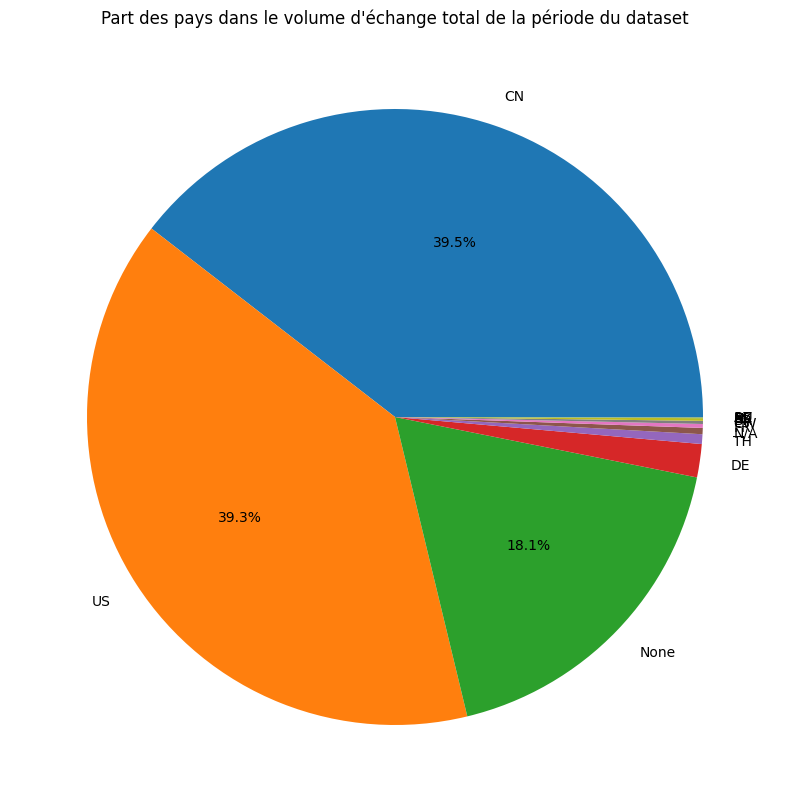

In [15]:
# countries = countries.drop(index='None')
# countries.plot.pie(use_index=True, y = 'volume', figsize=(10, 10))
threshold=5

def label_function(val):
    return '' if val < threshold else f'{val:.1f}%'

fig, ax = plt.subplots(figsize=(10, 10))
ax.pie(countries['volume'], labels=countries.index, autopct=label_function)

# set the font size of the labels
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontsize(16)

# set the title of the plot
ax.set_title("Part des pays dans le volume d'échange total de la période du dataset")

# show the plot
plt.show()

**On remarque que acteurs des Etats-Unis (US) avec 56.8% du volume et de la Chine (CN) avec 39.5% du volume occupent une majorité écrasante des échanges du Bitcoin. Cela concorde avec la situation économique et financière de ces deux pays qui sont considérés comme les deux puissances mondiales durant la période de 2015 à 2017.**

## 3. Part des pays en fonction du temps

Il faut maintenant analyser l'évolution des parts des pays dans le volume échangé.

In [16]:
country_dict = domains['country'].to_dict()

evolution = actors[actors['identity'].str.match('^[A-Za-z.]+$')]
evolution['volume'] = evolution['spent'] + evolution['received']
evolution['country']=''


evolution['country'] = evolution['identity'].map(country_dict)

evolution.head()

/var/folders/cd/mhyzdtwn1c54mvcxsky8p2vh0000gn/T/ipykernel_8153/3964309577.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evolution['volume'] = evolution['spent'] + evolution['received']
/var/folders/cd/mhyzdtwn1c54mvcxsky8p2vh0000gn/T/ipykernel_8153/3964309577.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evolution['country']=''
/var/folders/cd/mhyzdtwn1c54mvcxsky8p2vh0000gn/T/ipykernel_8153/3964309577.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

,identity,received,nb_received,date,sum_fee,mean_fee_for100,nb_transactions,sent,self_spent,self_spent_estimated,nb_spent,spent,volume,country
0,HappyCoins.com,1.377590e+09,4.0,2015-01-01,49596.0,0.004957,4.0,1.277500e+09,0.000000e+00,0.000000e+00,8.0,1.277500e+09,2.655090e+09,NL
2,FortuneJack.com,1.201470e+08,29.0,2015-01-01,83000.0,0.194670,11.0,1.541127e+08,1.415897e+07,1.415897e+07,22.0,1.399538e+08,2.601007e+08,None
4,SatoshiMines.com,7.401319e+08,193.0,2015-01-01,740000.0,0.447934,45.0,1.813624e+09,3.504457e+07,3.504457e+07,84.0,1.778579e+09,2.518711e+09,US
7,Rollin.io,5.091593e+07,31.0,2015-01-01,160000.0,3.341937,8.0,9.831120e+06,4.277201e+06,4.277201e+06,14.0,5.553919e+06,5.646985e+07,US
8,SatoshiDice.com,2.156347e+10,1160.0,2015-01-01,8710000.0,0.458686,613.0,4.091159e+10,1.960492e+10,1.960492e+10,1116.0,2.130667e+10,4.287014e+10,None


In [17]:
# Group the data by date and country and calculate the total volume for each group
df_grouped = evolution.groupby(['date', 'country'])['volume'].sum().reset_index()

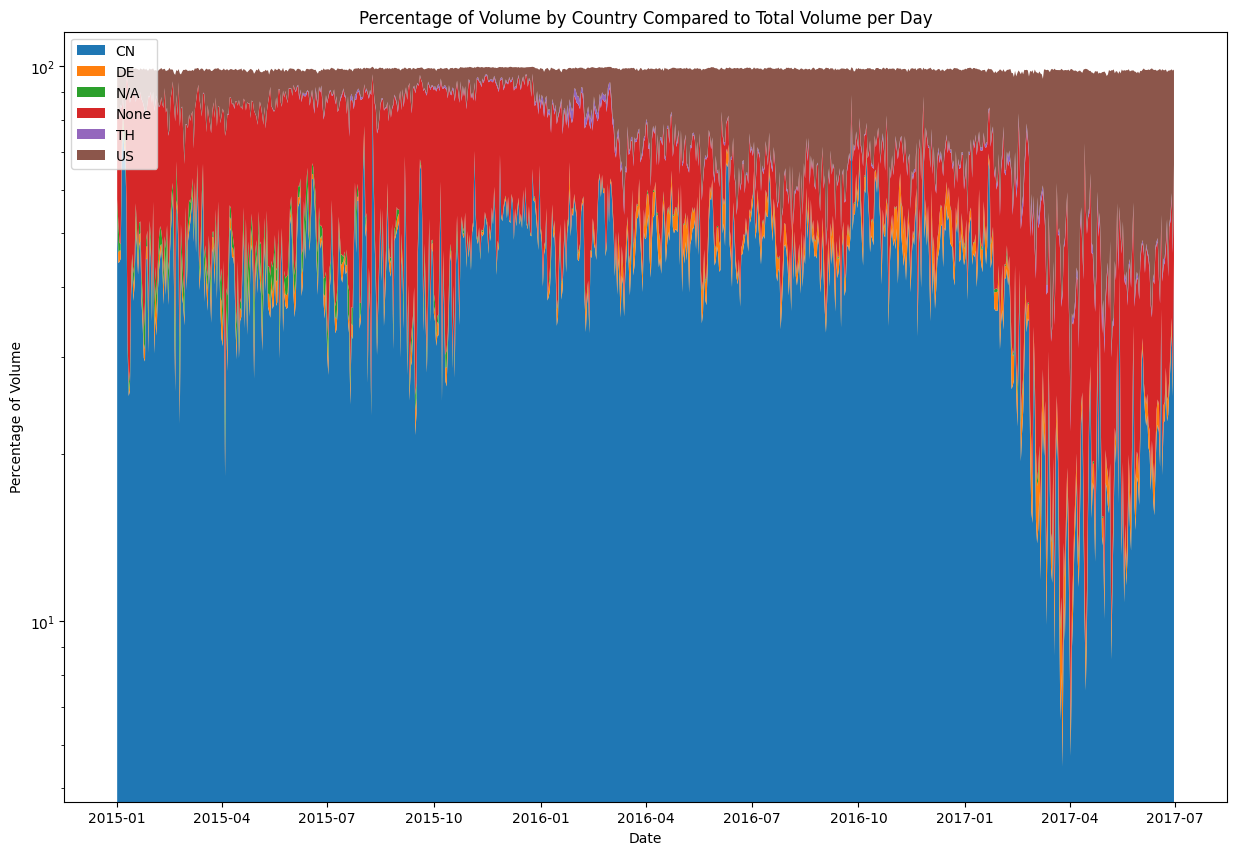

In [18]:
#grouped = df.groupby(['date', 'country'])['volume'].sum().reset_index()

# Pivot the data to get a DataFrame where each country is a column and the values are the total volumes
pivoted = df_grouped.pivot(index='date', columns='country', values='volume').fillna(0)

# Calculate the total volume for each date
total_volume = pivoted.sum(axis=1)

# Calculate the percentage of each country's volume for each date
percentage = pivoted.divide(total_volume, axis=0) * 100
percentage = percentage.drop(percentage.columns[percentage.mean() < 0.5], axis=1)
plt.figure(figsize=(15, 10))
# Create a stackplot of the percentage of volume for each country compared to the total volume per day
plt.stackplot(percentage.index, percentage.values.T, labels=percentage.columns)

plt.yscale('log')

# Set the axis labels and title
plt.xlabel('Date')
plt.ylabel('Percentage of Volume')
plt.title('Percentage of Volume by Country Compared to Total Volume per Day')

# Add a legend
plt.legend(loc='upper left')

# Show the plot
plt.show()

On remarque une soudaine baisse de la proportion des exchanges chinois en bleu autour de l'année 2017. Au contraire, les exchanges américains ont prit la proportion laissée vacante par les chinois. On zoome sur le graphe sur les années 2016 et 2017 pour mieux comprendre ce changement dans la dynamique du volume d'échanges du bitcoin.

Effectivement, le gouvernement Chinois à fermé de nombreuses plateformes de cryptomonaies ainsi que l'interdiction des ICO (méthode de financement qui consiste à émettre de nouveaux jetons numériques en cryptomonaie) cet année la et il y a eu de fortes répression sur le trading de cryptomonaies, notament le bitcoin, en Chine ce qui a amené à une plus grosse part de marché des États-Unis.

Cette répression est due au fait que la Chine ne peut pas controller ces cryptomonaies et donc avait peur de la fraude, de la spéculation et du blanchissement d'argent.

Le volume de trading de cryptomonnaies en Chine a donc considérablement diminué ce qui a envoyé les investisseurs sur d'autres plateformes de cryptomonaies, notament Americaines.

Voici quelques articles qui expliquent ce qui s'est passé et dont l'analyse explique ce phénomène :
* https://news.bitcoin.com/happened-to-bitcoin-in-china-2017/
* https://www.businessinsider.com/bitcoin-price-plunges-suddenly-and-sharply-march-8-2017-2017-3?r=US&IR=T
* http://cnbc.com/2017/09/04/bitcoin-digital-currency-price-falls-on-china-ico-ban.html

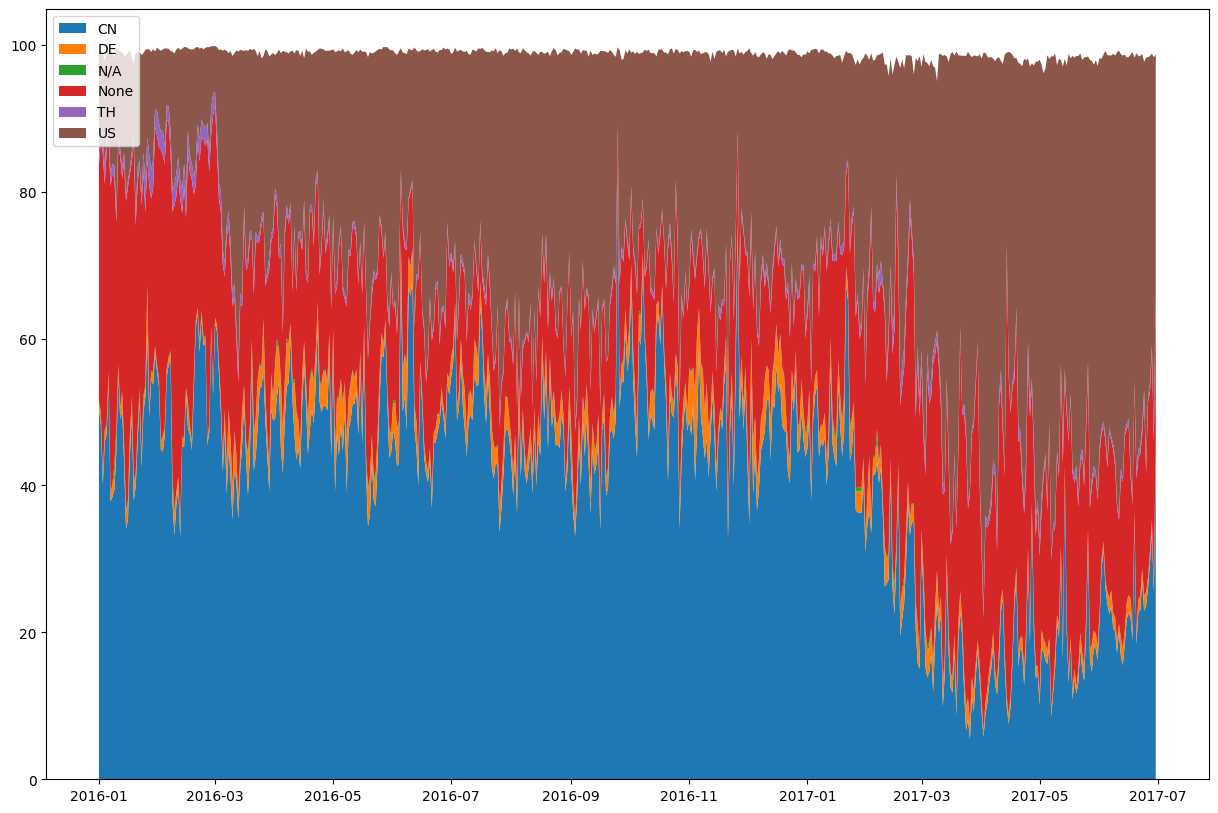

In [19]:
percentage_2017 = percentage.loc[percentage.index.year >= 2016]


plt.figure(figsize=(15, 10))
# Create a stacked area plot
plt.stackplot(percentage_2017.index, percentage_2017.transpose(), labels=percentage_2017.columns)
plt.legend(loc='upper left')
plt.show()

## 4. La correlation avec le cours du bitcoin

In [20]:
external = pd.read_csv('timeseries/external.csv')

external.drop(["Unnamed: 0", "HashRate"], axis=1, inplace=True)

external.fillna(0)

external["date"] = pd.to_datetime(external["date"])

<Axes: xlabel='date'>

<Figure size 1500x1000 with 0 Axes>

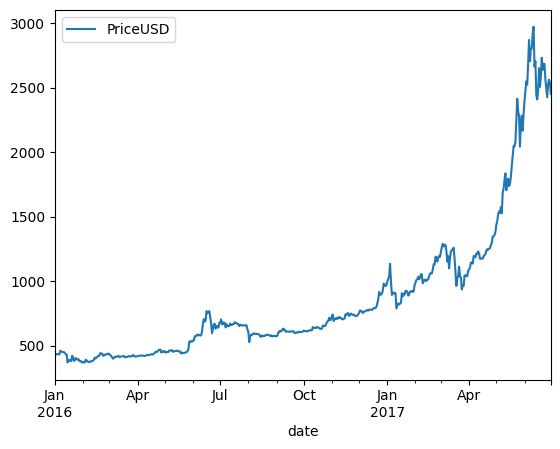

In [21]:
external.set_index("date", inplace=True)
price_2017 = external.loc[external.index.year >= 2016]
plt.figure(figsize=(15, 10))
price_2017.plot()

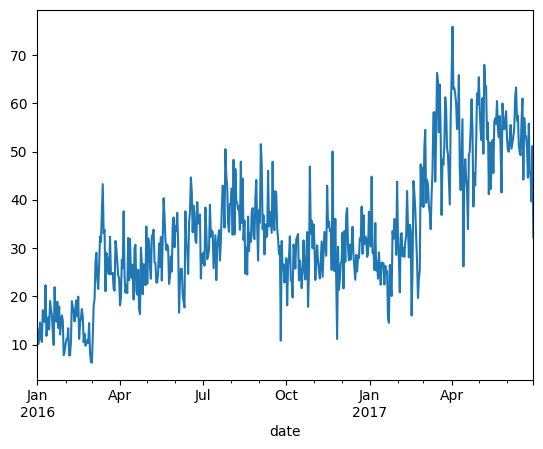

date
2016-01-01    13.299727
2016-01-02    10.091651
2016-01-03    11.242630
2016-01-04    14.579523
2016-01-05    11.414990
                ...    
2017-06-26    46.268663
2017-06-27    44.580262
2017-06-28    39.669372
2017-06-29    51.137650
2017-06-30    32.184604
Name: US, Length: 547, dtype: float64

In [22]:
us_pct = percentage_2017['US']
us_pct.plot()
plt.show()
us_pct

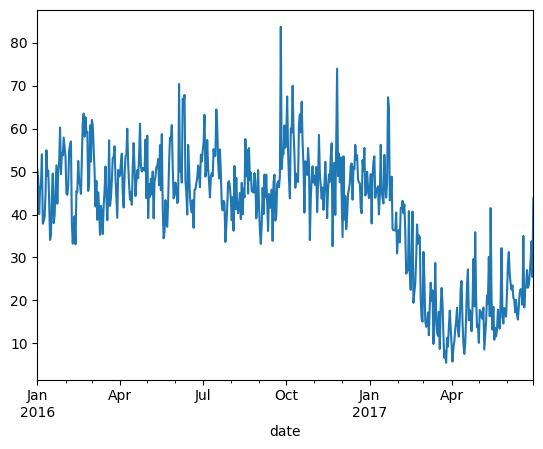

In [23]:
cn_pct = percentage_2017['CN']
cn_pct.plot()
plt.show()

In [24]:
corr = np.corrcoef(price_2017['PriceUSD'], us_pct)[0, 1]
print(f'Correlation coefficient: {corr}')

Correlation coefficient: 0.680349826179774


In [25]:
corr = np.corrcoef(price_2017['PriceUSD'], cn_pct)[0, 1]
print(f'Correlation coefficient: {corr}')

Correlation coefficient: -0.6531235906536247


Pendant la période allant de **2016 à 2017**, une **corrélation positive** est observée entre la croissance de la part de marché des échanges américains dans le volume des échanges de Bitcoin et la hausse du prix de celui-ci. En revanche, une **corrélation négative** est constatée entre la forte baisse de la part de marché chinoise et la hausse du prix de Bitcoin.

## Conclusion et hypthèse finale


L'hypothèse suivante pourrait être avancée pour expliquer l'augmentation du cours du Bitcoin en 2017, suite à la chute de la part de marché des exchanges chinois dans le volume de Bitcoin échangé, tandis que les exchanges américains ont fortement augmenté leur part :

L'année 2017 a été marquée par une forte volatilité des cours du Bitcoin, atteignant des niveaux historiques inédits. Plusieurs facteurs ont contribué à cette tendance haussière, mais l'un des plus importants a été la chute de la part de marché des exchanges chinois dans le volume de Bitcoin échangé. En effet, la Chine était un marché clé pour le Bitcoin, avec une part de marché estimée à plus de 80% en 2016. Cependant, en 2017, les régulateurs chinois ont pris des mesures pour limiter l'activité des exchanges de Bitcoin, en particulier en fermant les échanges sans licence et en imposant des restrictions aux échanges restants.

Cette décision a eu un impact significatif sur le volume de Bitcoin échangé en Chine, qui a chuté de manière importante. Cette chute a été compensée par une augmentation de la part de marché des exchanges américains, qui ont vu leur volume de Bitcoin échangé augmenter considérablement. Les investisseurs et les traders ont ainsi commencé à privilégier les exchanges américains, qui semblaient offrir une plus grande stabilité et une meilleure sécurité juridique. Cette tendance a été renforcée par la forte croissance des marchés à terme Bitcoin aux États-Unis.

L'augmentation de la part de marché des exchanges américains a eu un effet positif sur le cours du Bitcoin, car cela a contribué à renforcer la confiance des investisseurs dans la cryptomonnaie. Les investisseurs ont commencé à considérer le Bitcoin comme une véritable alternative aux monnaies traditionnelles, avec un potentiel de rendement élevé et une volatilité relativement faible par rapport aux autres cryptomonnaies. Cette perception a entraîné une augmentation de la demande pour le Bitcoin, ce qui a contribué à faire monter les prix.

En conclusion, l'augmentation du cours du Bitcoin en 2017 peut être expliquée en partie par la chute de la part de marché des exchanges chinois dans le volume de Bitcoin échangé et la forte augmentation de la part de marché des exchanges américains. Cette tendance a renforcé la confiance des investisseurs dans le Bitcoin, contribuant ainsi à augmenter la demande pour la cryptomonnaie et à faire monter les prix.